## 1-hot encoding, dummy variables

In [1]:
from QHyper.problems.community_detection import BrainNetwork


path = "../QHyper/problems/network_communities/brain_community_data"
data_name = "Edge_AAL90_Binary"

brain_network = BrainNetwork(input_data_dir=path, input_data_name=data_name)

<class 'networkx.utils.decorators.argmap'> compilation 5:5: FutureWarning: modularity_matrix will return a numpy array instead of a matrix in NetworkX 3.0.


In [4]:
from QHyper.problems.community_detection import CommunityDetectionProblem


brain_problem = CommunityDetectionProblem(brain_network, N_communities=4)

### Karate Club Problem

In [5]:
from QHyper.problems.community_detection import CommunityDetectionProblem, KarateClubNetwork, ObjFunFormula as off

karate_problem = CommunityDetectionProblem(KarateClubNetwork, N_communities=4, obj_func_formula=off.DICT)
karate_problem.dummy_coefficients

{x0: (s0, s1, s2, s3),
 x1: (s4, s5, s6, s7),
 x2: (s8, s9, s10, s11),
 x3: (s12, s13, s14, s15),
 x4: (s16, s17, s18, s19),
 x5: (s20, s21, s22, s23),
 x6: (s24, s25, s26, s27),
 x7: (s28, s29, s30, s31),
 x8: (s32, s33, s34, s35),
 x9: (s36, s37, s38, s39),
 x10: (s40, s41, s42, s43),
 x11: (s44, s45, s46, s47),
 x12: (s48, s49, s50, s51),
 x13: (s52, s53, s54, s55),
 x14: (s56, s57, s58, s59),
 x15: (s60, s61, s62, s63),
 x16: (s64, s65, s66, s67),
 x17: (s68, s69, s70, s71),
 x18: (s72, s73, s74, s75),
 x19: (s76, s77, s78, s79),
 x20: (s80, s81, s82, s83),
 x21: (s84, s85, s86, s87),
 x22: (s88, s89, s90, s91),
 x23: (s92, s93, s94, s95),
 x24: (s96, s97, s98, s99),
 x25: (s100, s101, s102, s103),
 x26: (s104, s105, s106, s107),
 x27: (s108, s109, s110, s111),
 x28: (s112, s113, s114, s115),
 x29: (s116, s117, s118, s119),
 x30: (s120, s121, s122, s123),
 x31: (s124, s125, s126, s127),
 x32: (s128, s129, s130, s131),
 x33: (s132, s133, s134, s135)}

In [6]:
import gurobipy as gp
from typing import Any
from QHyper.util import QUBO


problem = karate_problem
gpm = gp.Model("KarateProblem")


def calc(vars: dict[str, Any], poly_dict: QUBO) -> Any:
    cost_function: float = 0
    for key, value in poly_dict.items():
        tmp = 1
        for k in key:
            tmp *= vars[k]
        cost_function += tmp * value
    return cost_function


vars = {
    str(var_name): gpm.addVar(vtype=gp.GRB.BINARY, name=str(var_name))
    for _, v in problem.dummy_coefficients.items() for var_name in v
}

objective_function = calc(
    vars, problem.objective_function.as_dict()
)
gpm.setObjective(objective_function, gp.GRB.MINIMIZE)

for i, constraint in enumerate(problem.constraints):
    tmp_constraint = calc(vars, constraint.as_dict())
    gpm.addConstr(tmp_constraint == 0, f"constr_{i}")
    gpm.update()

gpm.optimize()

allvars = gpm.getVars()
solution = {}
for v in allvars:
    solution[v.VarName] = v.X

Restricted license - for non-production use only - expires 2024-10-28


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 34 rows, 136 columns and 136 nonzeros
Model fingerprint: 0x2737524e
Model has 2244 quadratic objective terms
Variable types: 0 continuous, 136 integer (136 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-02, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -3.8846154
Presolve time: 0.01s
Presolved: 2278 rows, 2380 columns, 6868 nonzeros
Variable types: 0 continuous, 2380 integer (2380 binary)

Root relaxation: objective -5.500000e+01, 68 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    

In [7]:
import os


def safe_open(path: str, permission: str) -> Any:
    """
    Open "path" for writing, creating any parent directories as needed.
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)
    return open(path, permission)

def write_to_file(solution: Any, solution_file: str) -> None:
    with safe_open(solution_file, "w") as file:
        file.write(str(solution))


solution_file = "demo/demo_output/brain_gurobi_solution.csv"
write_to_file(solution, solution_file)

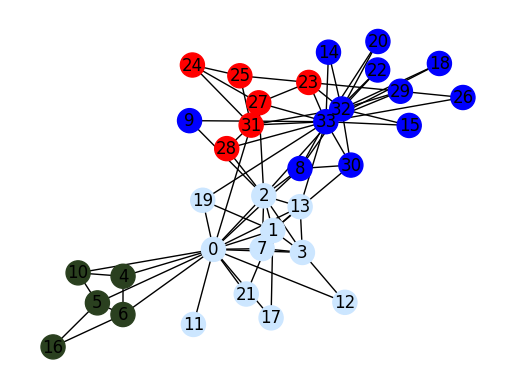

In [15]:
from QHyper.problems.network_communities.utils import COLORS
import matplotlib.pyplot as plt
import networkx as nx


decoded_solution = karate_problem.decode_dummies_solution(solution)

color_map = []
for node in problem.G:
    color_map.append(COLORS[decoded_solution[node]])

decoded_solution_file = "demo/demo_output/brain_gurobi_decoded_solution.csv"
write_to_file(decoded_solution, decoded_solution_file)

folder = "demo/demo_output"
data_name = "bcdp_gurobi_binary"
path = f"{folder}/{data_name}.png"

f = plt.figure()
nx.draw(
    problem.G,
    node_color=color_map,
    with_labels=True,
    ax=f.add_subplot(111),
)
f.savefig(path)